<a href="https://colab.research.google.com/github/Saksit-Jittasopee/AI-Workshop-2-Image-Processing/blob/main/ai_club_introduction_to_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio
!pip install datasets
!pip install scikit-learn
!pip install torcheval
!pip install matplotlib
!pip install numpy

In [ ]:
import torch
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_f1_score
)

In [ ]:
dt_train = load_dataset("ylecun/mnist", split="train")
dt_test = load_dataset("ylecun/mnist", split="test")
dt_train, dt_test

(Dataset({
     features: ['image', 'label'],
     num_rows: 60000
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 10000
 }))

In [ ]:
# Convert PIL Image to Tensor
transform = transforms.ToTensor()

def transform_to_torch(batch):
    batch["image"] = [transform(img) for img in batch["image"]]
    return batch

dt_train_torch = dt_train.with_transform(transform_to_torch)
dt_test_torch = dt_test.with_transform(transform_to_torch)
dt_train_torch, dt_test_torch

(Dataset({
     features: ['image', 'label'],
     num_rows: 60000
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 10000
 }))

In [ ]:
train_indices, valid_indices = train_test_split(
    range(len(dt_train_torch)),
    test_size=0.2,
    random_state=42,
    stratify=dt_train['label']
)

train_subset = Subset(dt_train_torch, train_indices)
valid_subset = Subset(dt_train_torch, valid_indices)

batch_size = 128
train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(dt_test_torch, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_dl), len(valid_dl), len(test_dl)

(375, 94, 79)

In [ ]:
sample = dt_train_torch[0]

print(sample["image"].shape)   # torch.Size([1, 28, 28]) (C, H, W)
print(sample["label"])

torch.Size([1, 28, 28])
5


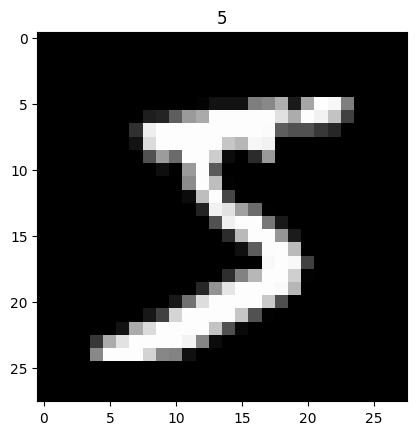

In [ ]:
plt.figure()
plt.title(sample["label"])
plt.imshow(sample["image"].permute(1, 2, 0), cmap="gray") # (H, W, C)
plt.show()

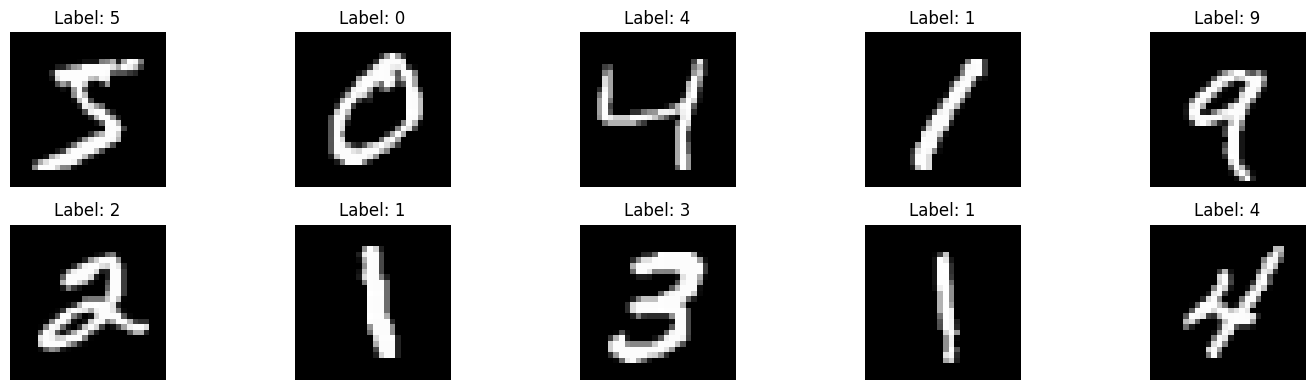

In [ ]:
plt.figure(figsize=(15, 4))

for i in range(10):
    sample = dt_train_torch[i]
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample['image'].permute(1, 2, 0), cmap='gray')
    plt.title(f"Label: {sample['label']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [ ]:
# Our Image size = 28 * 28 * 1 (Height, Width, Channel)
# We will use ReLu as our activation function
# You can try different activation functions (LeakyReLU, ELU, Tanh)
class AIC_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # Convert image to vector
        self.l1 = nn.Linear(28*28*1, 256)
        self.l2 = nn.Linear(256, 64)
        self.l3 = nn.Linear(64, 10)
    def forward(self, x):
        x = self.flatten(x)
        o1 = F.relu(self.l1(x)) # Activation Function
        o2 = F.relu(self.l2(o1))
        logits = self.l3(o2)
        return logits

model = AIC_Net().to(device)
model

AIC_Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
for batch in train_dl:
    imgs, lbls = batch['image'], batch['label']
    break
preds = model(imgs.to(device))
preds.shape

torch.Size([128, 10])

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
for x in model.parameters():
    print(x.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([64, 256])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [ ]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, epoch, log_step_interval=50):
    # Size of the dataset
    size = len(dataloader.dataset)

    # Training mode
    model.train()

    # Keep track of the loss
    running_loss = 0.
    last_loss = 0.

    # We use enumerate to track the batch index
    for i, batch in enumerate(dataloader):
        X, y = batch['image'], batch['label']
        X, y = X.to(device), y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Prediction (i.e., forward)
        pred = model(X)

        # Compute loss
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()  # calculate the backward gradients
        optimizer.step()  # adjust model's weights based on the observed gradients

        # Keep track of the loss
        running_loss += loss.item()
        if (i+1) % log_step_interval == 0:
            last_loss = running_loss / log_step_interval
            current = (i + 1) * len(X)
            print(f"loss: {last_loss:>7f}  [{current:>5d}/{size:>5d}]")
            running_loss = 0.

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Test mode
    model.eval()

    # Predict on test set
    loss, correct = 0, 0
    y_preds, y_trues = [], []
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch['image'], batch['label']
            X, y = X.to(device), y.to(device)
            # Prediction
            pred = model(X)
            y_pred = pred.argmax(1)
            # Compute loss
            loss += loss_fn(pred, y).item()
            # Performance metrics
            y_preds.append(y_pred)
            y_trues.append(y)
    y_preds = torch.cat(y_preds)
    y_trues = torch.cat(y_trues)

    # Average loss
    loss /= num_batches

    y_preds = y_preds.cpu()
    y_trues = y_trues.cpu()
    # Performance metrics
    perf = {
        'accuracy': multiclass_accuracy(y_preds, y_trues),
        'f1': multiclass_f1_score(y_preds, y_trues),
    }

    return loss, perf

In [ ]:
# Specify optimizer and Choose optimal Learning Rate for our model
# e.g., SGD, Adam, AdamW, RMSProp, etc.
# 1e-3 = 0.001, 1e-4 = 0.0001, 1e-5 = 0.00001
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#optimizer = torch.optim.RMSProp(model.parameters(), lr=1e-3)
# Try to find the sweet spot for optimizer and Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Too much epochs can lead to overfitting
epochs = 10
best_vloss = 100000.
hist = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
}
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_one_epoch(train_dl, model, loss_fn, optimizer, epoch)
    train_loss, train_perf = test(train_dl, model, loss_fn)
    val_loss, val_perf = test(valid_dl, model, loss_fn)

    # History for learning curve
    hist['train_loss'].append(train_loss)
    hist['val_loss'].append(val_loss)
    hist['train_acc'].append(train_perf['accuracy'])
    hist['val_acc'].append(val_perf['accuracy'])

    # Track best performance, and save the model's state
    if val_loss < best_vloss:
        best_vloss = val_loss
        torch.save(model.state_dict(), 'model_best_vloss.pth')
        print('Saved best model to model_best_vloss.pth')
print("Done!")

Epoch 1
-------------------------------
loss: 1.192123  [ 6400/48000]
loss: 0.420777  [12800/48000]
loss: 0.332059  [19200/48000]
loss: 0.308713  [25600/48000]
loss: 0.280676  [32000/48000]
loss: 0.244618  [38400/48000]
loss: 0.228897  [44800/48000]
Saved best model to model_best_vloss.pth
Epoch 2
-------------------------------
loss: 0.178050  [ 6400/48000]
loss: 0.175983  [12800/48000]
loss: 0.171246  [19200/48000]
loss: 0.161346  [25600/48000]
loss: 0.159388  [32000/48000]
loss: 0.158283  [38400/48000]
loss: 0.152291  [44800/48000]
Saved best model to model_best_vloss.pth
Epoch 3
-------------------------------
loss: 0.112472  [ 6400/48000]
loss: 0.121864  [12800/48000]
loss: 0.114102  [19200/48000]
loss: 0.116825  [25600/48000]
loss: 0.099841  [32000/48000]
loss: 0.111733  [38400/48000]
loss: 0.112612  [44800/48000]
Saved best model to model_best_vloss.pth
Epoch 4
-------------------------------
loss: 0.080431  [ 6400/48000]
loss: 0.086486  [12800/48000]
loss: 0.089759  [19200/4800

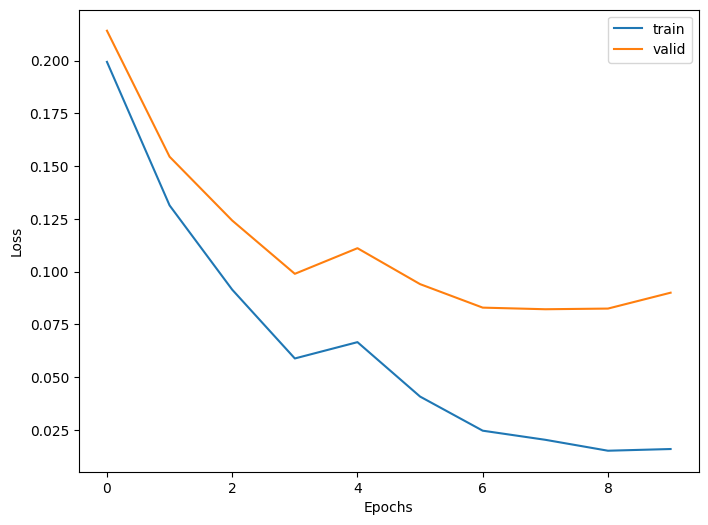

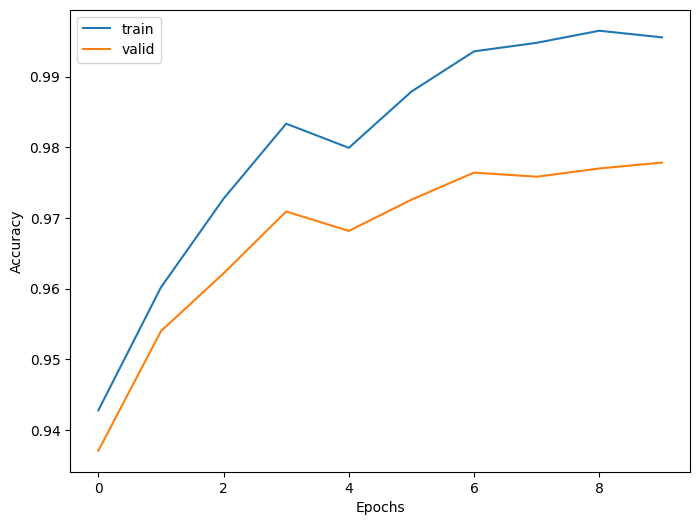

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(hist['train_loss'], label='train')
ax.plot(hist['val_loss'], label='valid')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(hist['train_acc'], label='train')
ax.plot(hist['val_acc'], label='valid')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

plt.close('all')

In [ ]:
model_best = AIC_Net().to(device)
model_best.load_state_dict(torch.load("model_best_vloss.pth"))

<All keys matched successfully>

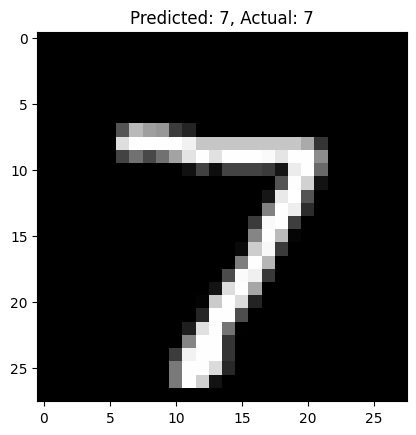

In [ ]:
model_best.eval()

# Get one batch of data
for batch in test_dl:
    imgs, lbls = batch['image'], batch['label']
    break

X, y = imgs[0:1].to(device), lbls[0:1].to(device)
with torch.no_grad():
    pred = model_best(X)
    predicted, actual = pred[0].argmax(0), y.cpu().item()

plt.figure()
plt.title(f"Predicted: {predicted}, Actual: {actual}")
plt.imshow(imgs[0].permute(1, 2, 0), cmap='gray')
plt.show()

In [ ]:
# Use the best model on the validation set
test_loss, test_perf = test(test_dl, model_best, loss_fn)
print(f"Test: loss={test_loss:>8f}, acc={(100*test_perf['accuracy']):>0.1f}%, f1={(100*test_perf['f1']):>0.1f}%")

Test: loss=0.074948, acc=97.8%, f1=97.8%


**Challenge**

1. Can you try to improve the model accuracy?

2. Try different architectures:
    - Shallow: [784 → 128 → 10]
    - Deep: [784 → 512 → 256 → 128 → 64 → 10]
    - Funnel: [784 → 512 → 256 → 128 → 10]
    - Wide: [784 → 1024 → 512 → 10]

    Does increasing the depth or size of a neural network always lead to better performance?

# Answer
## 1. I increases epoch from 5 to 10 and change optimizer from SGD to Adam. The Accuracy changes from 30% to 97.8%

## 2. No.